#**Sentiment Analysis using NLP**

#Import modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

# Step 1 - Load the Dataset

In [ ]:
data = pd.read_csv('/content/Tweets.csv')
data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
data.shape

(14640, 15)

In [ ]:
data = data[["airline_sentiment", "text"]]
data.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
data.shape

(14640, 2)

In [ ]:
data.groupby('airline_sentiment').describe()

text         \
                  count unique   
airline_sentiment                
negative           9178   9087   
neutral            3099   3067   
positive           2363   2298   

                                                                           
                                                                 top freq  
airline_sentiment                                                          
negative           @AmericanAir robocalls me with another Cancell...    2  
neutral                                           @SouthwestAir sent    5  
positive                                              @united thanks    5

In [ ]:
data = data.drop_duplicates(keep='first')

In [ ]:
data.groupby('airline_sentiment').describe()

text         \
                  count unique   
airline_sentiment                
negative           9087   9087   
neutral            3067   3067   
positive           2298   2298   

                                                                           
                                                                 top freq  
airline_sentiment                                                          
negative           @AmericanAir you have my money, you change my ...    1  
neutral            @AmericanAir we have 8 ppl so we need 2 know h...    1  
positive           @AmericanAir thank you we got on a different f...    1

In [ ]:
data = data.copy()
data["Length"] = data["text"].apply(len)

In [ ]:
data.head(2)

,airline_sentiment,text,Length
0,neutral,@VirginAmerica What @dhepburn said.,35
1,positive,@VirginAmerica plus you've added commercials t...,72


array([[<Axes: title={'center': 'negative'}>,
        <Axes: title={'center': 'neutral'}>],
       [<Axes: title={'center': 'positive'}>, <Axes: >]], dtype=object)

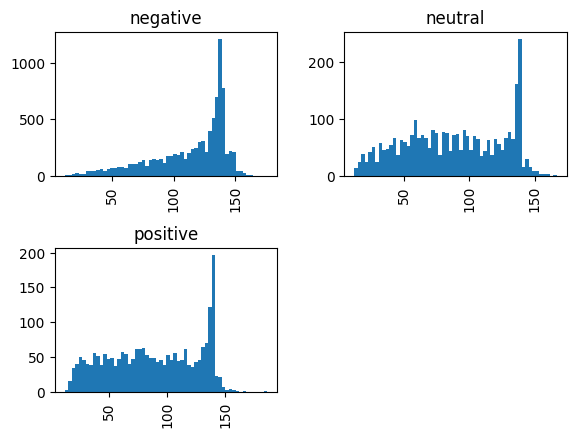

In [ ]:
data.hist(column='Length', by='airline_sentiment', bins=58)

# Step 2 - Preprocess Text

In [ ]:
import nltk
import string
import re
import pandas as pd

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

nltk.download('punkt_tab')
ps = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)
    tokens = nltk.word_tokenize(text)
    y = []

    for i in tokens:
        if i not in stopwords.words('english') and i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
data["text_cleaned"] = data["text"].apply(clean_text)
data.head()

,airline_sentiment,text,Length,text_cleaned
0,neutral,@VirginAmerica What @dhepburn said.,35,virginamerica dhepburn said
1,positive,@VirginAmerica plus you've added commercials t...,72,virginamerica plu ad commerci experi tacki
2,neutral,@VirginAmerica I didn't today... Must mean I n...,71,virginamerica today must mean need take anoth ...
3,negative,@VirginAmerica it's really aggressive to blast...,126,virginamerica realli aggress blast obnoxi ente...
4,negative,@VirginAmerica and it's a really big bad thing...,55,virginamerica realli big bad thing


# Step 3 - Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data["text_cleaned"]).toarray()
Y = data["airline_sentiment"].values
X.shape

(14452, 3000)

# Step 4 - Train Model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2)


In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))


Naive Bayes Accuracy: 0.7391905914908337


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.7734347976478727
